In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn
from torch.nn import functional as nnf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
from collections import defaultdict
import numpy as np

# Data

In [3]:
####################### data splits
train_data = pd.read_csv('train.csv', header=None)
val_data = pd.read_csv('val.csv', header=None)

x_train = train_data.iloc[:, 0].to_numpy()
y_train = train_data.iloc[:, 1].to_numpy()
x_val = val_data.iloc[:, 0].to_numpy()
y_val = val_data.iloc[:, 1].to_numpy()

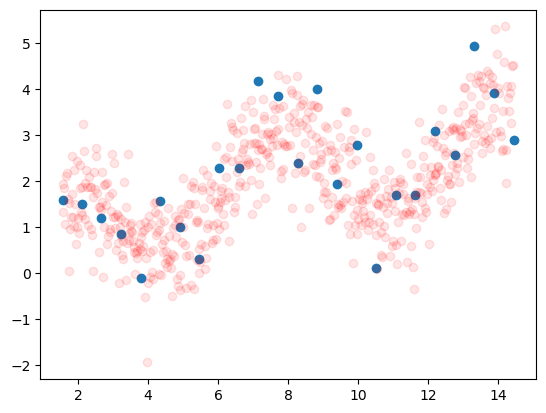

In [4]:
####################### visualization
plt.scatter(x_train, y_train)
plt.scatter(x_val, y_val, c='red', alpha=0.1)

# Dataset and model

In [5]:
####################### dataset
class MLPDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

####################### model, elegant solution
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        modules = []
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if not i == len(layer_sizes)-2:
                modules.append(nn.ReLU())

        self.layers = nn.Sequential(*modules)


    def forward(self, x):
        return self.layers(x)
    
####################### model, straight-forward solution
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(1, 32)
#         self.linear2 = nn.Linear(32, 64)
#         self.linear3 = nn.Linear(64, 128)
#         self.linear4 = nn.Linear(128, 256)
#         self.linear5 = nn.Linear(256, 128)
#         self.linear6 = nn.Linear(128, 64)
#         self.linear7 = nn.Linear(64, 32)
#         self.linear8 = nn.Linear(32, 1)

#         self.relu = nn.ReLU()


#     def forward(self, x):
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.linear3(x)
#         x = self.relu(x)
#         x = self.linear4(x)
#         x = self.relu(x)
#         x = self.linear5(x)
#         x = self.relu(x)
#         x = self.linear6(x)
#         x = self.relu(x)
#         x = self.linear7(x)
#         x = self.relu(x)
#         x = self.linear8(x)
#         return x

# Training loop without validation

In [6]:
####################### Training loop without validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")

# training parameters
epochs = 4000
batch_size = 24
lr = 0.001
layer_sizes = [1, 32, 64, 128, 256, 128, 64, 32, 1]

# training objects
trainset = MLPDataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
model = MLP(layer_sizes=layer_sizes).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# training loop
train_losses = []
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / len(trainloader)
    train_losses.append(train_loss)

The model is running on cuda.


100%|██████████| 4000/4000 [00:14<00:00, 271.53it/s]


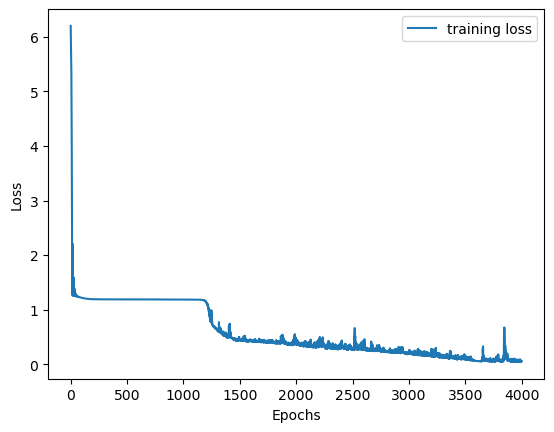

In [7]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, label='training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

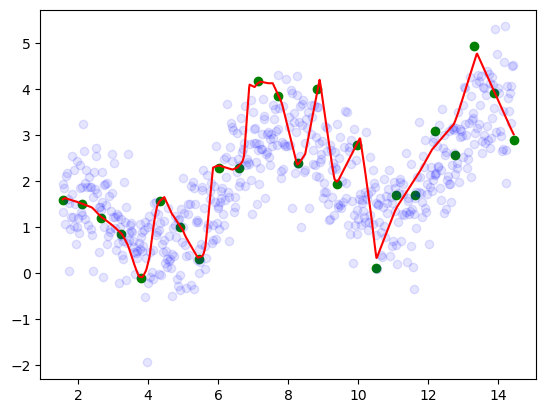

In [8]:
####################### plot predictions
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, c='blue', alpha=0.1)


min_x = np.min(x_train)
max_x = np.max(x_train)
x_seq = torch.linspace(min_x, max_x, 1000)[:, None].to(device)
model.eval()
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

# Training loop with validation

In [9]:
####################### Training loop without validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")

# training parameters
epochs = 4000
batch_size = 32
lr = 0.001
layer_sizes = [1, 32, 64, 128, 256, 128, 64, 32, 1]

# training objects
trainset = MLPDataset(x_train, y_train)
valset = MLPDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
model = MLP(layer_sizes=layer_sizes).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# training loop
train_losses = []
val_losses = []
min_val_loss = float('inf')
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0

    # training
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / len(trainloader)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch[:, None].float().to(device)
            y_batch = y_batch[:, None].float().to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            val_loss += loss.item()
    val_loss = val_loss / len(valloader)
    val_losses.append(val_loss)

    # save best model
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), '/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best.pth')
        min_val_loss = val_loss

The model is running on cuda.


100%|██████████| 4000/4000 [01:00<00:00, 66.55it/s]


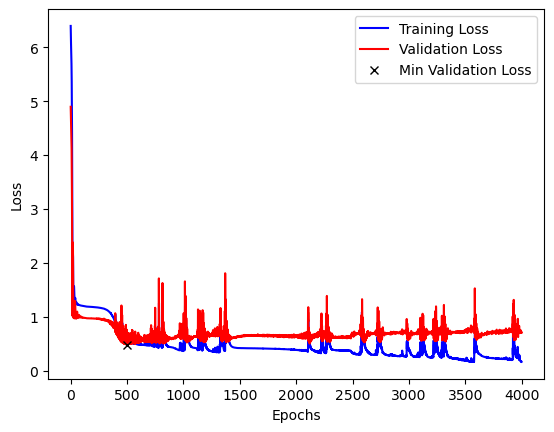

In [10]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
min_val_index = np.argmin(val_losses)
plt.plot(min_val_index+1, val_losses[min_val_index+1], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


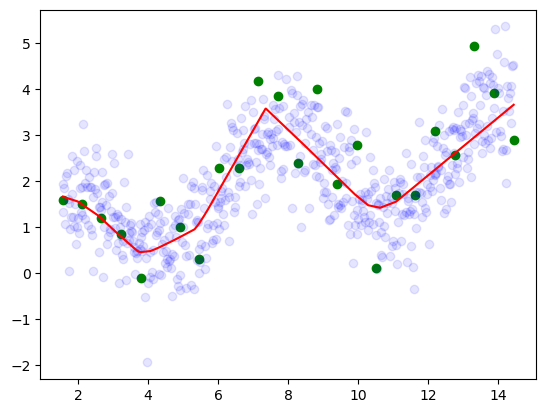

In [11]:
####################### plot predictions
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, c='blue', alpha=0.1)


min_x = np.min(x_train)
max_x = np.max(x_train)
x_seq = torch.linspace(min_x, max_x, 1000)[:, None].to(device)
model.eval()
model.load_state_dict(torch.load('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best.pth'))
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')

# Training loop with modular functions

In [15]:
def train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict=None):
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss = train_one_epoch(model, trainloader, optimizer, device)
        train_losses.append(train_loss)

        if epoch % val_interval == 0:
            val_loss = validate(model, valloader, device)
            val_losses.append(val_loss)

        if savepath_best_statedict is not None:
            if val_loss < min_val_loss:
                torch.save(model.state_dict(), savepath_best_statedict)
                min_val_loss = val_loss
    return train_losses, val_losses

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in trainloader:
        x_batch = x_batch[:, None].float().to(device)
        y_batch = y_batch[:, None].float().to(device)
        y_pred = model(x_batch)

        optimizer.zero_grad()
        loss = nnf.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch = x_batch[:, None].float().to(device)
            y_batch = y_batch[:, None].float().to(device)
            y_pred = model(x_batch)
            loss = nnf.mse_loss(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(valloader)

In [16]:
####################### Training loop with modular definition of training and validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on {device}.")

# training parameters
epochs = 4000
batch_size = 32
lr = 0.001
layer_sizes = [1, 32, 64, 128, 256, 128, 64, 32, 1]
val_interval = 1

# training objects
trainset = MLPDataset(x_train, y_train)
valset = MLPDataset(x_val, y_val)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)
model = MLP(layer_sizes=layer_sizes).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# training
train_losses, val_losses = train(model, trainloader, valloader, optimizer, epochs, device, val_interval, savepath_best_statedict='/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best.pth')

The model is running on cuda.


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:59<00:00, 66.88it/s]


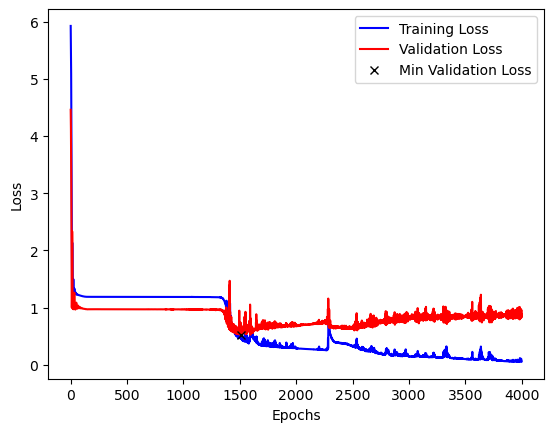

In [17]:
####################### plot losses
plt.plot(np.linspace(1, epochs, epochs), train_losses, c='blue', label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs), val_losses, c='red', label='Validation Loss')

# Mark the minimum validation loss
min_val_index = np.argmin(val_losses)
plt.plot(min_val_index+1, val_losses[min_val_index+1], 'kx', label='Min Validation Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


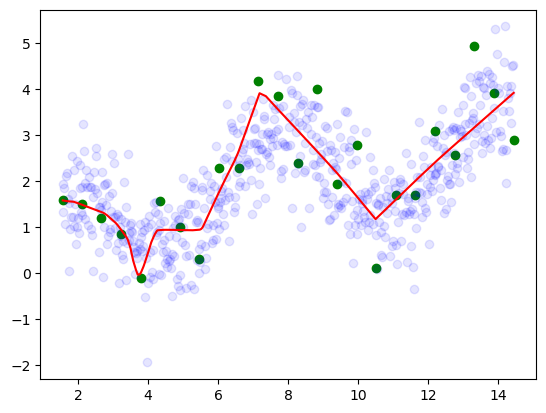

In [19]:
####################### plot predictions
plt.scatter(x_train, y_train, c='green')
plt.scatter(x_val, y_val, c='blue', alpha=0.1)

min_x = np.min(x_train)
max_x = np.max(x_train)
x_seq = torch.linspace(min_x, max_x, 1000)[:, None].to(device)
model.eval()
model.load_state_dict(torch.load('/usr/users/henrich1/repos/exercises_summer_school/exercises/mlp/best.pth'))
with torch.no_grad():
    y_seq = model(x_seq)
plt.plot(x_seq.cpu(), y_seq.cpu(), c='r')